# Twitter Data Analysis
## Predict inter-tweet times for a single user
### An implementation of the "Question", "Model", "Validate" process for data science.

In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
# Import libraries
from __future__ import print_function
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplt
import seaborn as sns

pyplt.rcParams['figure.figsize'] = (4, 3)

In [20]:
import datetime
from datetime import datetime
from datetime import timedelta
from datetime import time

def extract_features(tweet_list):
    returnList = []

    for tweet in tweet_list:

        timeOfDay = extractTimeOfDay(tweet)
        containsMention = extractContainsMention(tweet)
        containsURL = extractContainsURL(tweet)
        tweetLength = extractTweetLength(tweet)
        containsHashtag = extractContainsHashtag(tweet)
        isReply = extractIsReply(tweet)

        featureTuple = (timeOfDay, containsMention, containsURL, tweetLength, containsHashtag, isReply)

        returnList.append(featureTuple)

    return returnList

def extractTimeOfDay(tweet):
    ''' Returns: 'morning, afternoon, evening, night' '''

    returnString = None
    createdAtStr = None

    morningLeftEdge = time(11, 0, 0)
    afternoonLeftEdge = time(17, 0, 0) 
    eveningLeftEdge = time(22, 0, 0)
    midnight = time(23, 59, 59)
    nightLeftEdge = time(2, 0, 0)

    if "created_at" in tweet:
        createdAtStr = tweet["created_at"]
        createdDate = datetime.strptime(createdAtStr[:-11], "%a %b %d %H:%M:%S")

        asTime = time(createdDate.hour, createdDate.minute, createdDate.second)

        if morningLeftEdge<=asTime and asTime<=afternoonLeftEdge:
            returnString = "morning"
        elif afternoonLeftEdge<=asTime and asTime<=eveningLeftEdge:
            returnString = "afternoon"
        elif asTime>=eveningLeftEdge and asTime<=midnight:
            returnString = "evening"
        elif asTime<=nightLeftEdge:
            returnString = "evening"
        elif nightLeftEdge<=asTime and asTime<=morningLeftEdge:
            returnString = "night"

    return returnString


def extractContainsMention(tweet):

    returnFloat = 0.0

    if "user_mentions" in tweet:
        numMentions = len(tweet["user_mentions"])

        if numMentions>0:
            returnFloat = 1.0

    return returnFloat

def extractContainsURL(tweet):

    returnFloat = 0.0

    if "urls" in tweet:
        if len(tweet["urls"])>0:
            returnFloat = 1.0

    return returnFloat

def extractTweetLength(tweet):
    tweetText = tweet["text"]

    return len(tweetText)

def extractContainsHashtag(tweet):

    returnFloat = 0.0

    if "hashtags" in tweet:
        if len(tweet["hashtags"])>0:
            returnFloat = 1.0

    return returnFloat

def extractIsReply(tweet):
    returnFloat = 0.0

    if "in_reply_to_screen_name" in tweet:
        if tweet["in_reply_to_screen_name"] is not None:
            returnFloat = 1.0

    return returnFloat

### Load Data

In [21]:
tweetsDF = pd.io.json.read_json("new_gruber_tweets.json")

In [22]:
tweetsDF.columns

Index([u'coordinates', u'created_at', u'favorite_count', u'favorited', u'geo',
       u'hashtags', u'id', u'in_reply_to_screen_name',
       u'in_reply_to_status_id', u'in_reply_to_user_id', u'lang', u'place',
       u'retweet_count', u'retweeted', u'retweeted_status', u'source', u'text',
       u'truncated', u'urls', u'user', u'user_mentions'],
      dtype='object')

## Feature Selection
- For this analysis, we are going to focus on the times intervals between tweets as our major feature. This is captured in the variable `timeUntilNext`

In [23]:
createdDF = tweetsDF.ix[0:, ["created_at"]]
createdTextDF = tweetsDF.ix[0:, ["created_at", "text"]]
createdTextVals = createdTextDF.values #turn it into an array

In [24]:
tweetTimes = []

for i,row in createdDF.iterrows():
    tweetTimes.append(row["created_at"])
tweetTimes.sort()

In [25]:
timeUntilNext = []

for i in xrange(1, len(tweetTimes) - 1):
    timeDiff = (tweetTimes[i] - tweetTimes[i-1]).seconds
    timeUntilNext.append(timeDiff)

## Explore Data 
- Create initial histogram

In [26]:
timeToNextSeries = pd.Series(timeUntilNext)


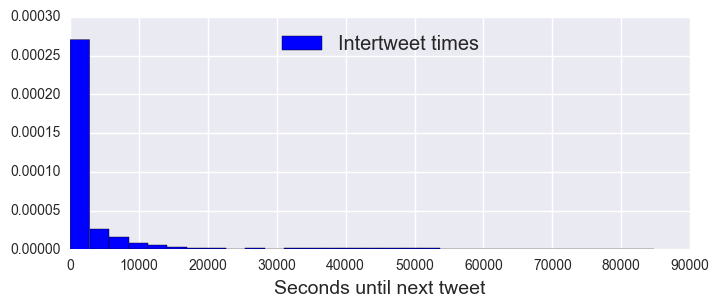

In [38]:
pyplt.rcParams['figure.figsize'] = (8, 3)

timeToNextSeries.hist(bins=30, normed=True, color="blue", label="Intertweet times")
pyplt.legend(loc='upper center', shadow=True, fontsize='x-large')
pyplt.xlabel('Seconds until next tweet', fontsize=14);


From these histograms, we see that the data looks like an exponential distribution. In industry, exponentials are used to model rare events like heart attacks, when a request will come into the file system and so on.

$$ y = \frac{1}{\beta} \,e^{\textstyle\frac{-y}{\beta}} $$

What we have to do is find the parameter $\beta$ and the probability density function (pdf) from which the observed data is most likely to have been produced. $X = $ time until next tweet 
$$f\{X = t\} = \frac{1}{\beta} \, e^{\textstyle\frac{-t}{\beta}} $$ We are using the $\beta$ as the number of seconds until the person tweets again.
## Fit Exponential


In [28]:
from scipy.optimize import curve_fit

In [29]:
def fitFunc(t, b):
    return b * numpy.exp(-b * t)

In [31]:
count, division = np.histogram(timeUntilNext, bins=100, normed=True)
fitParams, fitCov = curve_fit(fitFunc, division[0:len(division)-1], count, p0=1e-4)

In [34]:
print ("beta parameter", fitParams, "actual parameter is {} seconds".format(1/fitParams[0]))

beta parameter [ 0.00068895] actual parameter is 1451.48831924 seconds


#### Covariance Matrix gives one entry for each pair of parameters we are trying to fit for.
- It gives the number of times $\beta$ changed over many bootstrap samples
- This number amounts to the variance of that number
- The higher the value, the more that $\beta$ changed, the less certain we are, about the parameters value

In [36]:
fitCov 

array([[  1.04040928e-09]])

The covariance values for our data is *very* small, that means we can have strong confidence in the parameter.
### Evaluate the exponential function

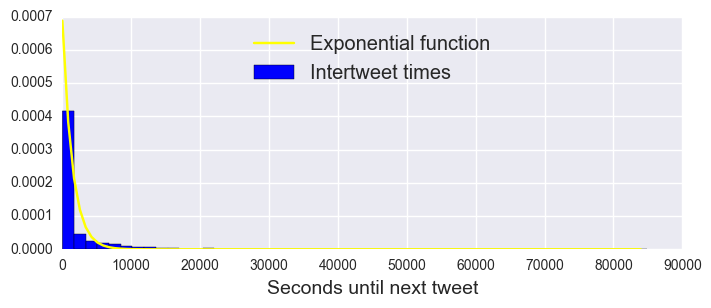

In [39]:
t = division[0:len(division)-1]


timeToNextSeries.hist(bins=50, normed=True, color="blue", label="Intertweet times")
pyplt.plot(t, fitFunc(t, fitParams[0]), color="yellow", label="Exponential function")
pyplt.legend(loc='upper center', shadow=True, fontsize='x-large')
pyplt.xlabel('Seconds until next tweet', fontsize=14);

## Confidence bounds and data
- How sure are we that $\beta$ is correct? Well, that depends on the number of datapoints we have!

We can quantify the *uncertainty* of our $\beta$ by using **Chebyshev's inequality** $ P\{ |\bar{X} - \beta^*| > \epsilon \} \leq 1/4n\epsilon^{2}  $, which states that the absolute value of the deviation of our estimated $\beta^*$ from the actual value of $\beta$, the probability of that being greater than $\epsilon$ is $1/4n\epsilon^{2}$.   

If we solve this equation for $n$, you will see that we would need a larger amount of datapoints than the ones we have. As such, lets see if we can get a tighter bound. Luckily we can using **Hoeffding's Inequality**. It is *still* subject to $n$, the number of datapoints we have, but it is much better. $ P\{ |\bar{X} - \beta^*| > \epsilon \} \leq 2e^{-2n \epsilon^{2}}  $

In [48]:
exp_diffs = [] # difference between our estimate and the actual
for t in timeUntilNext:
    exp_diffs.append(t - (1/fitParams[0])) #signed difference of the actual from the predicted
                                           # signed error

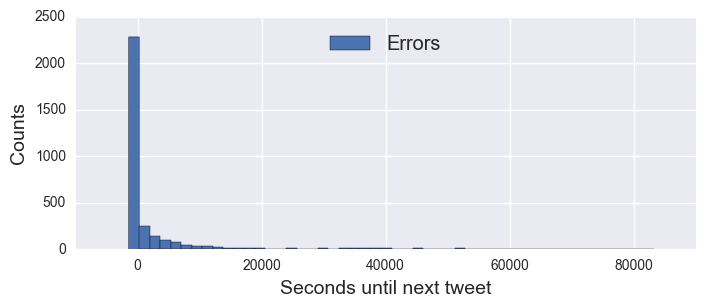

In [49]:
pd.Series(exp_diffs).hist(bins=50, label="Errors")
pyplt.legend(loc='upper center', shadow=True, fontsize='x-large')
pyplt.xlabel('Seconds until next tweet', fontsize=14)
pyplt.ylabel('Counts', fontsize=14);

In [46]:
pd.Series(exp_diffs).describe()

count     3232.000000
mean      2843.046025
std      11064.424336
min      -1450.488319
25%      -1368.488319
50%      -1115.488319
75%       1032.261681
max      83356.511681
dtype: float64

In [47]:
pd.Series(exp_diffs).describe()['50%'] / 60

-18.591471987293929

This shows that 50% of the time, we are overestimating our inter-tweet prediction time by around 19 seconds

#### Evaluate absolute difference of values

In [50]:
import math


exp_diffs = []
abs_diffs = []
for t in timeUntilNext:
    exp_diffs.append(t - (1/fitParams[0]))
    abs_diffs.append(math.fabs(t - (1/fitParams[0]))) #signed absolute error


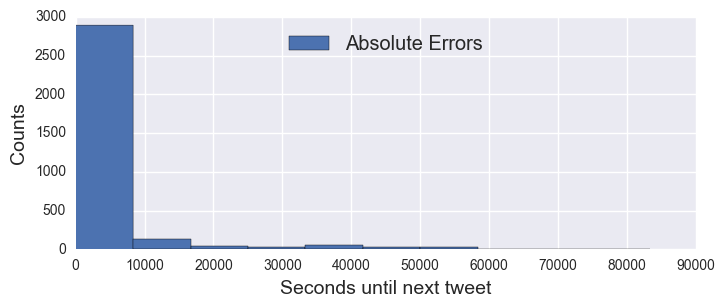

In [51]:
pd.Series(abs_diffs).hist(label="Absolute Errors")
pyplt.legend(loc='upper center', shadow=True, fontsize='x-large')
pyplt.xlabel('Seconds until next tweet', fontsize=14)
pyplt.ylabel('Counts', fontsize=14);

In [52]:
pd.Series(abs_diffs).describe()

count     3232.000000
mean      4446.834434
std      10522.663236
min          0.488319
25%       1110.505840
50%       1363.488319
75%       1437.488319
max      83356.511681
dtype: float64

#### Observe effect of adding offset

Note that much of the histogram occurs *before* zero. Perhaps by adding an offset, we can improve the accuracy of our model. To do that, we are going to fit a more generalized exponential function.

#### Fit more generalized exponential
- Ajdusted model
$$ y = a \, (\frac{1}{\beta} \, e^{\textstyle\frac{-t}{\beta}}) + c $$


In [53]:
def fitFunc_gen(t, a, b, c):
    return a * (b) * numpy.exp(-b * t) + c

In [54]:
fitParams_gen, fitCov_gen = curve_fit(fitFunc_gen, division[0:len(division)-1], count, p0=[0, 3e-4, 0])

In [55]:
a,b,c = fitParams_gen
print ("a = {}\nb = {}\nc = {}\n".format(a, b, c))


a = 0.33414957859
b = 0.00217218730911
c = 3.18496892421e-06



In [56]:
print (fitCov_gen)

[[  1.10186661e-04  -6.83152390e-07  -1.07612173e-09]
 [ -6.83152390e-07   4.65228418e-09   5.59704086e-12]
 [ -1.07612173e-09   5.59704086e-12   4.82402255e-13]]


In [59]:
print ("Expectation of t, E[t] = {} seconds\n".format((1 / (fitParams_gen[1])) * fitParams_gen[0] + fitParams_gen[2]))

Expectation of t, E[t] = 153.830926139 seconds



### Evaluate adjusted exponential

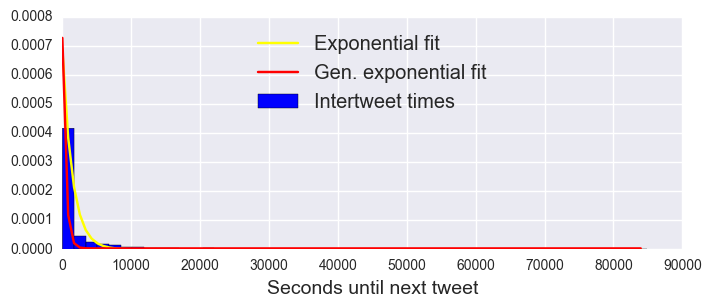

In [60]:
t = division[0:len(division)-1]

timeToNextSeries.hist(bins=50, normed=True, color="blue", label="Intertweet times")
pyplt.plot(t, fitFunc(t, fitParams[0]), color="yellow", label="Exponential fit")
pyplt.plot(t, fitFunc_gen(t, fitParams_gen[0], fitParams_gen[1], fitParams_gen[2]), color="red", label="Gen. exponential fit")
pyplt.legend(loc='upper center', shadow=True, fontsize='x-large')
pyplt.xlabel('Seconds until next tweet', fontsize=14)
pyplt.ylabel('', fontsize=14);

In [61]:
exp_gen_diffs = []
exp_gen_abs = []
for t in timeUntilNext:
    exp_gen_diffs.append((t-1/fitParams_gen[1]) * fitParams_gen[0] + fitParams_gen[1])
    exp_gen_abs.append(math.fabs((t-1/fitParams_gen[1]) * fitParams_gen[0] + fitParams_gen[1]))

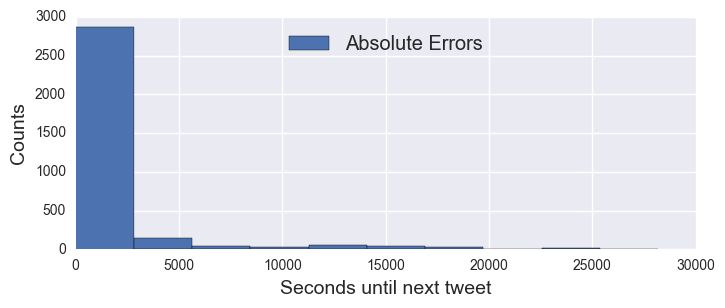

In [64]:
pd.Series(exp_gen_abs).hist(label="Absolute Errors")
pyplt.legend(loc='upper center', shadow=True, fontsize='x-large')
pyplt.xlabel('Seconds until next tweet', fontsize=14)
pyplt.ylabel('Counts', fontsize=14);

In [62]:
pd.Series(exp_gen_diffs).describe()

count     3232.000000
mean      1281.188091
std       3697.172729
min       -153.494601
25%       -126.094336
50%        -41.554492
75%        676.115265
max      28184.728710
dtype: float64

In [63]:
pd.Series(exp_gen_abs).describe()

count     3232.000000
mean      1400.959394
std       3653.456235
min          0.119945
25%        107.716109
50%        139.126169
75%        676.115265
max      28184.728710
dtype: float64

## Examining the sources of prediction error 
### Depection of variance in data


In [67]:
tweetsDF = pandas.io.json.read_json("new_gruber_tweets.json")

#### Obtaining time-to-tweet vs. delta-t data points

In [68]:
step_size = 10
data_points = []
for v in timeUntilNext:
    bin_left_edges = np.arange(0, v, step_size)
    
    for l_edge in bin_left_edges:
        tempNewPoint = [l_edge, v-l_edge]
        data_points.append(tempNewPoint)

In [69]:
data_points.sort()

In [70]:
deltat_100 = [v[1] for v in data_points if v[0]==100]
deltat_150 = [v[1] for v in data_points if v[0]==150]
deltat_10 = [v[1] for v in data_points if v[0]==10]

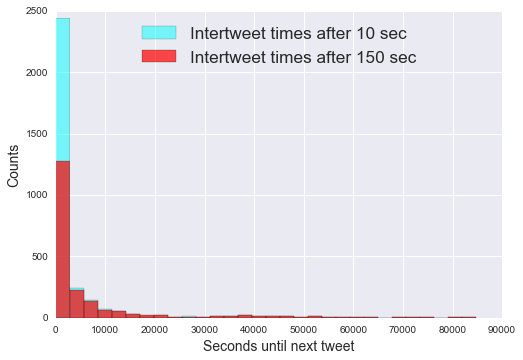

In [99]:
_= pandas.Series(deltat_10).hist(bins=30, alpha=0.5, color="cyan", label="Intertweet times after 10 sec")
_= pandas.Series(deltat_150).hist(bins=30, alpha=0.7, color="red", label="Intertweet times after 150 sec")
_= pyplt.legend(loc='upper center', shadow=True, fontsize='x-large')
_= pyplt.xlabel('Seconds until next tweet', fontsize=14)
_= pyplt.ylabel('Counts', fontsize=14)



In [83]:
deltatToStd = []
deltaToDist = []
for i in np.arange(0, 100, 10):
    tempDeltas = [v[1] for v in data_points if v[0] == i]
    tempStd = scipy.std(tempDeltas)
    deltatToStd.append([i, tempStd])
    deltaToDist.append([i, tempDeltas])

In [84]:
xVals = [v[0] for v in deltatToStd]
yVals = [v[1] for v in deltatToStd]

In [85]:
scipy.std(deltat_150)

13381.17044359403

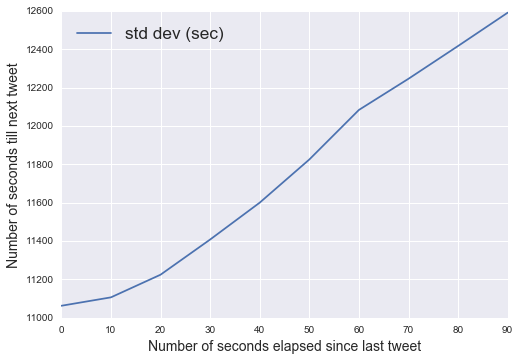

In [91]:
_= pyplt.plot(xVals, yVals, label="std dev (sec)")
_= pyplt.legend(loc='upper left', fontsize='x-large')
_= pyplt.xlabel('Number of seconds elapsed since last tweet', fontsize=14)
_= pyplt.ylabel('Number of seconds till next tweet', fontsize=14)

#### Obtain bounds on bootstrapped 95% confidence interval

In [92]:
deltaToBounds = []
for v in deltaToDist:
    topBound = numpy.percentile(v[1], 95)
    bottomBound = numpy.percentile(v[1], 5)
    deltaToBounds.append([v[0], (topBound, bottomBound)])

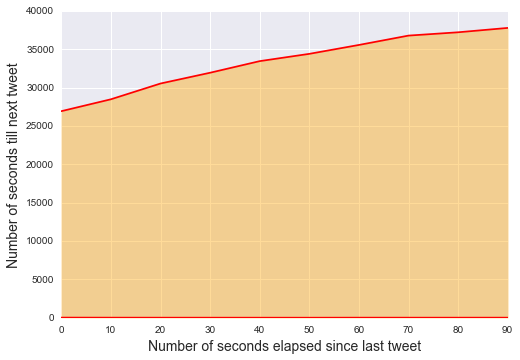

In [97]:
_= pyplt.plot(xVals, [e[1][0] for e in deltaToBounds], color="red")
_= pyplt.plot(xVals, [e[1][1] for e in deltaToBounds], color="red")
pyplt.fill_between(xVals, [e[1][0] for e in deltaToBounds], [e[1][1] for e in deltaToBounds], 
                   alpha=0.4, color="orange")
_= pyplt.xlabel('Number of seconds elapsed since last tweet', fontsize=14)
_= pyplt.ylabel('Number of seconds till next tweet', fontsize=14)

This graph shows that as time goes on the confidence band increases. This is just another way of saying, that as time goes on, we are more and more uncertain of how long it will be until they tweet next. Any estimator we build using this data will be *averaging* this spread. Fundamentally, this data suffers from **inherent** [variance](https://classroom.udacity.com/courses/ud919/lessons/3104518651/concepts/31003987850923).

### Question:
- What is the cause of the spread we see in the data?
There are two possible causes of this spread
    - 1) It could be because the underlying process that generates the data is random. If that is the case, the best we can do is use our exponential function to model it.
    - 2) On the other hand, the spread could be caused because if factors we have not modeled-NOISE.

If it is 2) we can reduce the effect of noise in our data by finding the factors on which inter-tweet time depends.


### Impact of unmeasured features
#### One variable plus gaussian noise

In [100]:
dataPoints_1 = []
x = np.arange(0, 100, 10)
for j in xrange(100):
    points = [(i, i*2 + 3 + numpy.random.normal(scale=50.0)) for i in x]
    dataPoints_1.extend(points)

In [101]:
pointToVals = []
pointToBounds = []
for i in np.arange(0, 100, 10):
    valsForDataPoint = [v for v in dataPoints_1 if v[0]==i]
    pointToVals.append(valsForDataPoint)
    upperBound = numpy.percentile(valsForDataPoint, 95)
    lowerBound = numpy.percentile(valsForDataPoint, 5)
    pointToBounds.append([i, (upperBound, lowerBound)])

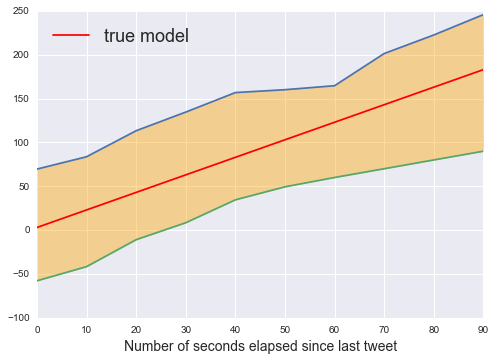

In [104]:
pyplt.plot(x, [v[1][0] for v in pointToBounds])
pyplt.plot(x, [v[1][1] for v in pointToBounds])
pyplt.plot(x, [[i*2+3] for i in x], color="red", label="true model")
pyplt.fill_between(x, [v[1][0] for v in pointToBounds], [v[1][1] for v in pointToBounds], color="orange", alpha=0.4)
_= pyplt.legend(loc=2, prop={'size':18})
_= pyplt.xlabel('Number of seconds elapsed since last tweet', fontsize=14)

#### Two variables plus gaussian noise
- To investigate the impact of *uncaptured* features on prediction, lets extend our test model from $f(x) = 2x + 3 + noise $ to a two feature model $f(x) = 2x + 2y+ noise $
- We will not change the training data to reflect two features. 


In [105]:
dataPoints_2 = []
x = np.arange(0, 100, 10)
y = np.arange(50, 150, 10)
for j in xrange(100):
    yVal = random.choice(y)
    points = [(i, i*2 + yVal*2 + 3 + numpy.random.normal(scale=50.0)) for i in x]
    dataPoints_2.extend(points)

In [106]:
avgYAtX = {}
for i in x:
    lineVals = [(i*2 + yVal*2 + 3 ) for yVal in np.arange(50, 150, 10)]
    avgY = reduce(lambda x,y: x+y, lineVals)/len(lineVals)
    avgYAtX[i] = avgY

In [107]:
pointToVals = []
pointToBounds = []
for i in np.arange(0, 100, 10):
    valsForDataPoint = [v for v in dataPoints_2 if v[0]==i]
    pointToVals.append(valsForDataPoint)
    upperBound = numpy.percentile(valsForDataPoint, 95)
    lowerBound = numpy.percentile(valsForDataPoint, 5)
    pointToBounds.append([i, (upperBound, lowerBound)])

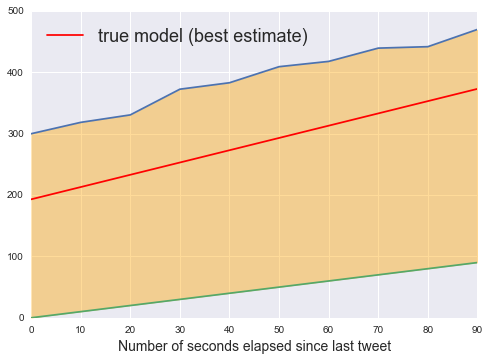

In [109]:
pyplt.plot(x, [v[1][0] for v in pointToBounds])
pyplt.plot(x, [v[1][1] for v in pointToBounds])
pyplt.plot(x, [avgYAtX[i] for i in x], color="red", label="true model (best estimate)")
pyplt.fill_between(x, [v[1][0] for v in pointToBounds], [v[1][1] for v in pointToBounds], color="orange", alpha=0.4)
_=pyplt.legend(loc=2, prop={'size':18})
_= pyplt.xlabel('Number of seconds elapsed since last tweet', fontsize=14)

### Feature selection
Proposed list of features to consider for influence upon intertweet time:
- mention distance
- time of day
- contains mention
- contains URL
- length of tweet (num chars)
- contains hashtags
- is_reply

We now need to form the features described above. The most non-trivial one to create is "mention distance", as defined in lecture. We do this now. 

#### Create mention distance

In [110]:
import twitter_tools
from twitter_tools import *
import json

Obtain your own data files here!

In [142]:
tweetFile = open("new_gruber_tweets.json")
jsonFile = json.load(tweetFile)
tweetFile.close()

In [143]:
gruberTweetsDF = pandas.io.json.read_json("new_gruber_tweets.json")
siracusaTweetsDF = pandas.io.json.read_json("new_siracusa_tweets.json")
armentTweetsDF = pandas.io.json.read_json("new_arment_tweets.json")

In [144]:
gruberTimeDiffs = []
gruberTweetTimes = []
gruberTimeToDiff = {}
gruberTimeToText = {}
siracusaMentionTimes = []
armentMentionTimes = []

In [145]:
gruberCreatedDF = gruberTweetsDF.ix[0:, ["created_at"]]
gruberCreatedTextDF = gruberTweetsDF.ix[0:, ["created_at", "text"]]
createdTextVals = gruberCreatedTextDF.values

for i, row in gruberCreatedDF.iterrows():
    gruberTweetTimes.append(row["created_at"])

In [146]:
gruberTweetTimes.sort()

In [147]:
for i in xrange(1, len(gruberTweetTimes)):
    timeDiff = (gruberTweetTimes[i]-gruberTweetTimes[i-1]).seconds
    gruberTimeDiffs.append(timeDiff)
    gruberTimeToDiff[gruberTweetTimes[i]] = timeDiff
    gruberTimeToText[gruberTweetTimes[i]] = gruberCreatedTextDF[gruberCreatedTextDF["created_at"]==gruberTweetTimes[i]]

### Capture time of mentions

In [148]:
nearestMentionToTimeDiff = []
tweetIndexToNearestMention = {}

In [149]:
def findTweetFollowingTime(timeStamp, tweetTimes):
    returnTweetTime = None
    
    for t in tweetTimes:
        if t>timeStamp:
            returnTweetTime = t
            break
    
    return returnTweetTime

def findTweetPreceedingTime(timeStamp, tweetTimes):
    returnTweetTime = None
    
    i = len(tweetTimes)-1
    
    while i>=0:
        t = tweetTimes[i]
        if t<timeStamp:
            returnTweetTime = t
            break
        
        i-=1
    
    return returnTweetTime

In [150]:
siracusaTimeOfGruberMentions = []
armentTimeOfGruberMentions = []

In [151]:
for i, row in armentTweetsDF.iterrows():
    if "user_mentions" in row:
        if type(row["user_mentions"]) == list:
            if len([e for e in row["user_mentions"] if e["screen_name"]=="gruber"])>0:
                armentTimeOfGruberMentions.append(row["created_at"])

In [152]:
for i, row in siracusaTweetsDF.iterrows():
    if "user_mentions" in row:
        if type(row["user_mentions"]) == list:
            if len([e for e in row["user_mentions"] if e["screen_name"]=="gruber"])>0:
                siracusaTimeOfGruberMentions.append(row["created_at"])

### Mention distance for each @gruber tweet
For each gruber tweet, let's find the tweet belonging to either @siracusa or @marcoarment which is the closest, in time, to mention @gruber

In [153]:
gruberTweetTimes.sort()
siracusaTimeOfGruberMentions.sort()
armentTimeOfGruberMentions.sort()
for i in xrange(len(gruberTweetTimes)):
    t = gruberTweetTimes[i]
    t_next = None
    if i+1<len(gruberTweetTimes):
        t_next = gruberTweetTimes[i+1]
        
        #print "t_next: %s" % t_next
        t_s = findTweetFollowingTime(t, siracusaTimeOfGruberMentions)
        t_s_prev = findTweetPreceedingTime(t, siracusaTimeOfGruberMentions)
        
        #print "t_s: %s" % t_s
        
        t_a = findTweetFollowingTime(t, armentTimeOfGruberMentions)
        t_a_prev = findTweetPreceedingTime(t, armentTimeOfGruberMentions)
        
        sDiff = None
        aDiff = None
        if t_s_prev is not None and t_s is not None: 
            sDiff = math.fabs((t_s - t).seconds)
            if sDiff >math.fabs((t-t_s_prev).seconds):
                sDiff = math.fabs((t-t_s_prev).seconds)
            
        if t_a_prev is not None and t_a is not None:
            aDiff = math.fabs((t_a - t).seconds)
            if aDiff > math.fabs((t-t_a_prev).seconds):
                aDiff = math.fabs((t - t_a_prev).seconds)
        
        closestMention = None
        
        if sDiff is not None:
            closestMention = sDiff
        elif aDiff is not None:
            closestMention = aDiff
        
        if aDiff is not None and sDiff is not None:
            if aDiff < sDiff:
                closestMention = aDiff
                
        if closestMention is not None:
            nearestMentionToTimeDiff.append((closestMention, (t_next-t).seconds))
            tweetIndexToNearestMention[i] = closestMention

#### Extract remaining features

In [125]:
features_list = extract_features(jsonFile)

In [126]:
featuresWithLabel = []
for i in range(len(gruberTimeDiffs)):
    timeDiff = gruberTimeDiffs[i]
    if timeDiff<4000:
        label = "short"
    else:
        label = "long"
    
    featuresForTweet = features_list[i]
    
    nearestMention = 0
    if i in tweetIndexToNearestMention:
        nearestMention = tweetIndexToNearestMention[i]
    
    completeItem = []
    completeItem.append(label)
    completeItem.extend(list(featuresForTweet))
    completeItem.append(nearestMention)
    featuresWithLabel.append(completeItem)

### Evaluate features by mutual information gain

In [154]:
from info_gain import *

### 1) Time of day

In [155]:
valsY = ["short", "long"]
binsY = None

joint_list = [(v[1], v[0]) for v in featuresWithLabel]
valsX = ["morning", "afternoon", "evening", "night"]
binsX = None

jpTable = compute_joint_prob(joint_list, valsX, valsY, None, None)
print "Entropy loss for Time of Day feature is {}".format(entropy_loss(jpTable, valsX, valsY))

Entropy loss for Time of Day feature is 0.000297923289112


### 2) Contains mention

In [156]:
joint_list = [(v[2], v[0]) for v in featuresWithLabel]
valsX = None
binsX = [[0, .9], [1.0, 100]]

jpTable = compute_joint_prob(joint_list, valsX, valsY, bins1=binsX)

print "Entropy loss for Contain Mention feature is {}".format(entropy_loss(jpTable, [0.0, 1.0], valsY))

Entropy loss for Contain Mention feature is 0.000185921715885


### 3) Contains URL

In [157]:
joint_list = [(v[3], v[0]) for v in featuresWithLabel]
valsX = None
binsX = [[0, .9], [1.0, 100]]

jpTable = compute_joint_prob(joint_list, valsX, valsY, bins1=binsX)
print "Entropy loss for Contains URL feature is {}".format(entropy_loss(jpTable, [0.0, 1.0], valsY))

Entropy loss for Contains URL feature is 0.00069178412888


### 4) Length of tweet

In [158]:
joint_list = [(v[4], v[0]) for v in featuresWithLabel]
valsX = None
binsX = [[0, 14], [14, 28], [28, 42], [42, 56], [56, 70], [70, 84], [84, 98], [98, 112], [112, 126]]

jpTable = compute_joint_prob(joint_list, valsX, valsY, bins1=binsX)
print "Entropy loss for Contains URL feature is {}".format(entropy_loss(jpTable, 
                                                           [v[4] for v in featuresWithLabel], valsY))

Entropy loss for Contains URL feature is 3.18446759664


### 5) Contains hashtags

In [160]:
joint_list = [(v[5], v[0]) for v in featuresWithLabel]
valsX = None
binsX = [[0, .9], [1.0, 100]]

jpTable = compute_joint_prob(joint_list, valsX, valsY, bins1=binsX)
print "Entropy loss for Contains Hashtags feature is {}".format(entropy_loss(jpTable, [0.0, 1.0], valsY))

Entropy loss for Contains Hashtags feature is 2.47181497266e-05


### 6) Is reply

In [161]:
joint_list = [(v[6], v[0]) for v in featuresWithLabel]
valsX = None
binsX = [[0, .9], [1.0, 100]]

jpTable = compute_joint_prob(joint_list, valsX, valsY, bins1=binsX)
print "Entropy loss for Contains Hashtags feature is {}".format(entropy_loss(jpTable, [0.0, 1.0], valsY))

Entropy loss for Contains Hashtags feature is 7.18875313335e-05


### 7) Mention distance

In [163]:
joint_list = [(v[7], v[0]) for v in featuresWithLabel]
valsX = None
binsX = [[0, 1000], [1000, 5000], [5000, 8000], [8000, 10000], [10000, 20000], 
         [20000, 30000], [30000, 60000], [60000, 80000], [80000, 10000], [100000, 800000]]

jpTable = compute_joint_prob(joint_list, valsX, valsY, bins1=binsX)
print "Entropy loss for Contains Hashtags feature is {}".format(entropy_loss(jpTable, [0.0, 1.0], valsY))

Entropy loss for Contains Hashtags feature is 2.06503854245


## Fitting a new model 
Obtain data points - each point is of the form (delta-t, mention distance, text-length of last tweet) - label with time until next tweet
### kNN

In [165]:
# Form data points to be used with kNN model
step_size = 10
knn_data_points = []
tweet_index = 0
for v in timeUntilNext:
    bin_left_edges = np.arange(0, v, step_size)
    
    features_for_tweet = features_list[tweet_index]
    
    if tweet_index in tweetIndexToNearestMention:
        for l_edge in bin_left_edges:
            newDeltaT = l_edge
            mentionDist = tweetIndexToNearestMention[tweet_index] + newDeltaT
            textLength = features_for_tweet[3]
            label = v-l_edge
            
            newPoint = [newDeltaT, mentionDist, textLength, label]
            knn_data_points.append(newPoint)
    
    tweet_index+=1

In [166]:
import sklearn
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(5)
knn_3 = KNeighborsRegressor(3)

print len(knn_data_points)
print .70*len(knn_data_points)
print .30*len(knn_data_points)

1381258
966880.6
414377.4


In [167]:
import random

trainingPoints = [random.choice(knn_data_points) for i in xrange(966880)]
trainingX = [(v[0], v[1], v[2]) for v in trainingPoints]
trainingY = [v[3] for v in trainingPoints]

m_3 = knn_3.fit(trainingX, trainingY)
m = knn.fit(trainingX, trainingY)

#### Performance on training set

In [169]:
y_ = m.predict(trainingX)
y = m_3.predict(trainingX)

In [170]:
train_diffs = []
for i in xrange(len(trainingY)):
    train_diffs.append(trainingY[i] - y_[i])

In [171]:
pandas.Series([math.fabs(x) for x in train_diffs]).describe()

count    966880.000000
mean       1876.534920
std        4723.392699
min           0.000000
25%           4.000000
50%           8.000000
75%        1065.800000
max       67504.400000
dtype: float64

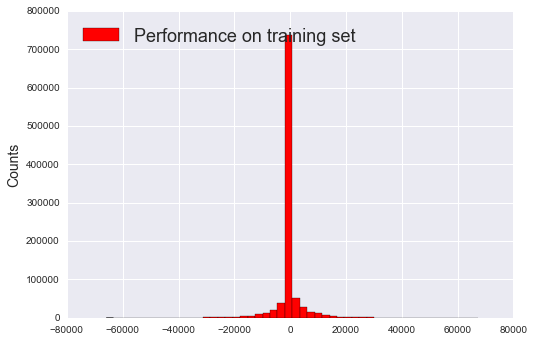

In [193]:
_= pandas.Series(train_diffs).hist(bins=50, color="red", label="Performance on training set")
_= pyplt.xlabel('', fontsize=14)
_= pyplt.ylabel('Counts', fontsize=14)
_= pyplt.legend(loc=2, prop={'size':18})

#### Performance on test set

In [173]:
testPoints = [random.choice(knn_data_points) for i in xrange(414377)]

In [174]:
testX = [(v[0], v[1], v[2]) for v in testPoints]

In [175]:
testY = [v[3] for v in testPoints]

In [176]:
test_pred = m_3.predict(testX)

In [177]:
test_diffs = []
for i in xrange(len(testY)):
    test_diffs.append(math.fabs(testY[i] - test_pred[i]))

In [178]:
pandas.Series(test_diffs).describe()

count    414377.000000
mean       1857.298908
std        5612.142850
min           0.000000
25%           3.333333
50%           6.666667
75%          33.333333
max       82735.333333
dtype: float64

In [179]:
testSeries = pandas.Series(test_diffs)

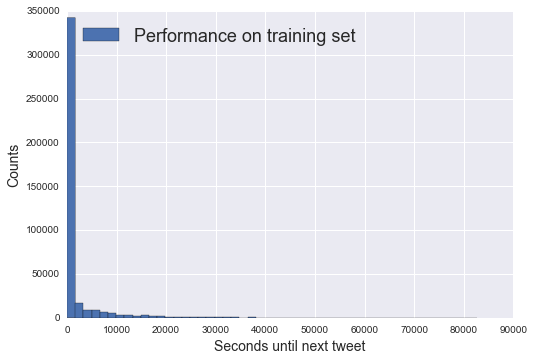

In [194]:
_=testSeries.hist(bins=50, label="Performance on training set")
_= pyplt.xlabel('Seconds until next tweet', fontsize=14)
_= pyplt.ylabel('Counts', fontsize=14)
_= pyplt.legend(loc=2, prop={'size':18})